# Лабораторная работа №7

### Вариант №7

In [ ]:
import matplotlib.pyplot as plt
import math
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots


# Источниковый член в выражении ∂²u/∂x² + ∂²u/∂y² + a * ∂u/∂x + b * ∂u/∂y + cu = f
def f(x, y):
  return 0

# Граничные условия для x
def phi_1(y):
    return math.cos(y)

def phi_2(y):
    return 0

# Граничные условия для y
def phi_3(x):
    return math.cos(x)

def phi_4(x):
    return 0

# Аналитическое решение
def solution(x, y):
    return math.cos(x) * math.cos(y)

"""
система имеет вид:

∂²u/∂x² + ∂²u/∂y² + a * ∂u/∂x + b * ∂u/∂y + cu = f
α₁ * ∂/∂x u(0, y) + β₁ * u(0, y) = φ₁(y)
α₂ * ∂/∂x u(l₁, y) + β₂ * u(l₁, y) = φ₂(y)
α₃ * ∂/∂y u(x, 0) + β₃ * u(x, 0) = φ₃(x)
α₄ * ∂/∂y u(x, l₂) + β₄ * u(x, l₂) = φ₄(x)
"""

# Параметры задачи
l_1 = math.pi / 2 # Граница по x
l_2 = math.pi / 2 # Граница по y
h_x_desired = 0.05 # Желаемый шаг по x
h_y_desired = 0.05 # Желаемый шаг по y

a=0 # Коэффициент перед ∂u/∂x
b=0 # Коэффициент перед ∂u/∂y
c=2 # Коэффициент перед u

alpha_1=0 # Коэффициент перед ∂/∂x u(0, y)
beta_1=1 # Коэффициент перед u(0, y)

alpha_2=0 # Коэффициент перед ∂/∂x u(l₁, y)
beta_2=1 # Коэффициент перед u(l₁, y)

alpha_3=0 # Коэффициент перед ∂/∂y u(x, 0)
beta_3=1 # Коэффициент перед u(x, 0)

alpha_4=0 # Коэффициент перед ∂/∂y u(x, l₂)
beta_4=1 # Коэффициент перед u(x, l₂)

cur_init=True # флаг управления линейной интерполяции неизвестных компонент

cur_theta=1.5 # коэффициент метода верхней релаксации (для получения просто Зейделя нужен коэффициент = 1), в методе простых итераций не используется

cur_eps=1e-7 # точность решения

cur_dir="↘" #↘↙↖↗ - всевозможные обходы матрицы

In [59]:
def interpolate_linearly(start_val, end_val, num_points):
    """
    Функция линейной интерполяции между двумя точками.
    Возвращает массив из num_points значений между start_val и end_val.
    """
    return np.linspace(start_val, end_val, num_points)

def interpolate_2d_matrix(res):
    """
    Интерполяция двумерной матрицы res по значениям её границ.
    Поддерживаются различные комбинации границ для интерполяции.

    Параметры:
    res: np.ndarray
        Матрица для интерполяции.

    Возвращает:
    np.ndarray
        Интерполированная матрица.
    """
    n, m = res.shape

    # Интерполяция для верхней и левой границ
    if res[0, 1:-1].any() and res[1:-1, 0].any():  # res[0][j] и res[i][0]
        for i in range(1, n):
            for j in range(1, m):
                res[i, j] = interpolate_linearly(res[0, j], res[i, 0], i + j + 1)[i]

    # Интерполяция для верхней и правой границ
    elif res[0, 1:-1].any() and res[1:-1, -1].any():  # res[0][j] и res[i][-1]
        for i in range(1, n):
            for j in range(0, m - 1):
                res[i, j] = interpolate_linearly(res[0, j], res[i, -1], i + (m - j))[i]

    # Интерполяция для нижней и правой границ
    elif res[-1, 1:-1].any() and res[1:-1, -1].any():  # res[-1][j] и res[i][-1]
        for i in range(0, n - 1):
            for j in range(0, m - 1):
                res[i, j] = interpolate_linearly(res[-1, j], res[i, -1], (n - i) + (m - j) - 1)[n - i - 1]

    # Интерполяция для нижней и левой границ
    elif res[-1, 1:-1].any() and res[1:-1, 0].any():  # res[-1][j] и res[i][0]
        for i in range(0, n - 1):
            for j in range(1, m):
                res[i, j] = interpolate_linearly(res[-1, j], res[i, 0], (n - i) + j)[n - i - 1]

    # Интерполяция для верхней и нижней границ
    elif res[0, 1:-1].any() or res[-1, 1:-1].any():  # res[0][j] и res[-1][j]
        for j in range(m):
            res[1:-1, j] = interpolate_linearly(res[0, j], res[-1, j], n)[1:-1]

    # Интерполяция для левой и правой границ
    elif res[1:-1, 0].any() or res[1:-1, -1].any():  # res[i][0] и res[i][-1]
        for i in range(n):
            res[i, 1:-1] = interpolate_linearly(res[i, 0], res[i, -1], m)[1:-1]

    else:
        print(
            "От interpolate_2d_matrix: Ваша матрица не подходит ни под один из вариантов интерполяции. "
            "Она осталась неизменной."
        )

    return res

In [60]:
def diff_scheme(
    x_range, # (x_begin, x_end) диапазон значений x
    y_range, # (y_begin, y_end) диапазон значений y
    h_x, # Длина шага по x
    h_y, # Длина шага по y
    a=0, # Коэффициент перед ∂u/∂x
    b=0, # Коэффициент перед ∂u/∂y
    c=1, # Коэффициент перед u
    f=f, # Источниковый член в выражении ∂²u/∂x² + ∂²u/∂y² + a * ∂u/∂x + b * ∂u/∂y = f
    alpha_1=1, # Коэффициент перед ∂/∂x u(0, y)
    beta_1=0, # Коэффициент перед u(0, y)
    alpha_2=1, # Коэффициент перед ∂/∂x u(l₁, y)
    beta_2=-1, # Коэффициент перед u(l₁, y)
    alpha_3=0, # Коэффициент перед ∂/∂y u(x, 0)
    beta_3=1, # Коэффициент перед u(x, 0)
    alpha_4=0, # Коэффициент перед ∂/∂y u(x, l₂)
    beta_4=1, # Коэффициент перед u(x, l₂)
    phi_1=phi_1, # Граничное условие для 0 по x
    phi_2=phi_2, # Граничное условие для l₁ по x
    phi_3=phi_3, # Граничное условие для 0 по y
    phi_4=phi_4, # Граничное условие для l₂ по y
    initial=True, # флаг управления линейной интерполяции неизвестных компонент
    method_name="Метод простых итераций", # название используемого метода
    theta=1, # коэффициент метода верхней релаксации (для получения просто Зейделя нужен коэффициент = 1), в методе простых итераций не используется
    eps=1e-3, # точность решения
    direction_of_traversing_the_matrix="↘", #↘↙↖↗ - всевозможные обходы матрицы
):
    """
    Решает эллиптическое дифференциальное уравнения, используя конечно-разностную схему и один из численных методов для системы уравнений.
    Возвращает матрицу U со значениями функции
    """

    x = np.arange(*x_range, h_x)
    y = np.arange(*y_range, h_y)
    n = len(x)
    m = len(y)

    res = np.zeros((n, m)) # Такое объявление означает, что x отвечает за вектор направленный ровно вниз, а y за вектор, направленный вправо
    # Если перефразировать: x - первый индекс, y - второй индекс двумерной матрицы

    # Шаг 1. Инициализация сетки с граничными условиями:

    # Строки 0, m -> используем граничные условия для x (если они первого рода α_i = 0)
    for cur_y_id in range(m):
        if alpha_1 == 0:
          res[0][cur_y_id] = 1 / beta_1 * phi_1(y[cur_y_id])
        if alpha_2 == 0:
          res[-1][cur_y_id] = 1 / beta_2 *  phi_2(y[cur_y_id])

    # Столбцы 0, n -> используем граничные условия для y (если они первого рода α_i = 0)
    for cur_x_id in range(n):
        if alpha_3 == 0:
          res[cur_x_id][0] = 1 / beta_3 * phi_3(x[cur_x_id])
        if alpha_4 == 0:
          res[cur_x_id][-1] = 1 / beta_4 * phi_4(x[cur_x_id])

    # Интерполяцию делаем относительно известных строк или столбцов
    if initial == True:
      interpolate_2d_matrix(res)

    iters = 1
    while True:
      res_prev = res
      res = np.zeros((n, m))
      # Шаг 1. Инициализация сетки с граничными условиями первого порядка
      # Строки 0, m -> используем граничные условия для x (если они первого рода α_i = 0)
      for cur_y_id in range(m):
          if alpha_1 == 0:
            res[0][cur_y_id] = 1 / beta_1 * phi_1(y[cur_y_id])
          if alpha_2 == 0:
            res[-1][cur_y_id] = 1 / beta_2 * phi_2(y[cur_y_id])
      # Столбцы 0, n -> используем граничные условия для y (если они первого рода α_i = 0)
      for cur_x_id in range(n):
          if alpha_3 == 0:
            res[cur_x_id][0] = 1 / beta_3 * phi_3(x[cur_x_id])
          if alpha_4 == 0:
            res[cur_x_id][-1] = 1 / beta_4 * phi_4(x[cur_x_id])

      # Шаг 2. Внутренние точки посчитаем через точки предыдущей матрицы
      all_traversings = "↘↙↖↗"
      traversing_information = [ # Описание четвёрок (x_start, x_end, y_start, y_end) у каждого направления обхода
                                (1, n - 2, 1, m - 2),  #↘ сверху вниз по [1, n - 2], слева направо по [1, m - 2]
                                (1, n - 2, m - 2, 1),  #↙ сверху вниз по [1, n - 2], справа налево по [m - 2, 1] (ОО)
                                (n - 2, 1, m - 2, 1),  #↖ снизу вверх по [n - 2, 1] (ОО), снизу вверх по [m - 2, 1] (ОО)
                                (n - 2, 1, 1, m - 2),  #↗ снизу вверх по [n - 2, 1] (ОО), слева направо по [1, m - 2]
                               ] # ОО - обратный обход
      index_of_traversing = all_traversings.find(direction_of_traversing_the_matrix)
      x_start, x_end, y_start, y_end = traversing_information[index_of_traversing]
      x_dir = np.sign(x_end - x_start) # Узнаём направление обхода по x
      y_dir = np.sign(y_end - y_start) # Узнаём направление обхода по y

      uij_coeff = (c - 2 / h_x**2 - 2 / h_y**2)
      for cur_x_id in range(x_start, x_end + x_dir, x_dir): # Python не включает граничную току поэтому для её рассмотрения делаем шаг дальше
        for cur_y_id in range(y_start, y_end + y_dir, y_dir):
          if method_name == "Метод простых итераций":
            part_d2u_dx2 = 1 / h_x**2 * (res_prev[cur_x_id + x_dir][cur_y_id] + res_prev[cur_x_id - x_dir][cur_y_id])
            part_d2u_dy2 = 1 / h_y**2 * (res_prev[cur_x_id][cur_y_id + y_dir] + res_prev[cur_x_id][cur_y_id - y_dir])
            du_dx = a / (2 * h_x) * (res_prev[cur_x_id + x_dir][cur_y_id] - res_prev[cur_x_id - x_dir][cur_y_id])
            du_dy = b / (2 * h_y) * (res_prev[cur_x_id][cur_y_id + y_dir] - res_prev[cur_x_id][cur_y_id - y_dir])

            res[cur_x_id][cur_y_id] = 1 / uij_coeff * (f(x[cur_x_id], y[cur_y_id]) - (part_d2u_dx2 + part_d2u_dy2 + du_dx + du_dy))

          elif method_name in ["Метод Зейделя", "Метод верхней релаксации"]:
            part_d2u_dx2 = 1 / h_x**2 * (res_prev[cur_x_id + x_dir][cur_y_id] + res[cur_x_id - x_dir][cur_y_id])
            part_d2u_dy2 = 1 / h_y**2 * (res_prev[cur_x_id][cur_y_id + y_dir] + res[cur_x_id][cur_y_id - y_dir])
            du_dx = a / (2 * h_x) * (res_prev[cur_x_id + x_dir][cur_y_id] - res[cur_x_id - x_dir][cur_y_id])
            du_dy = b / (2 * h_y) * (res_prev[cur_x_id][cur_y_id + y_dir] - res[cur_x_id][cur_y_id - y_dir])

            res[cur_x_id][cur_y_id] = (
                                        theta * (1 / uij_coeff * (f(x[cur_x_id], y[cur_y_id]) - (part_d2u_dx2 + part_d2u_dy2 + du_dx + du_dy))) +
                                        (1 - theta) * res_prev[cur_x_id][cur_y_id]
                                      )

          else:
            raise ValueError(f"Неправильное название метода, {method_name} не подходит ни под один из списка:\nМетод простых итераций\nМетод Зейделя\nМетод верхней релаксации")

      # Шаг 3. Инициализация сетки с граничными условиями второго и третьего порядков (α_i ≠ 0)
      for cur_y_id in range(1, m - 1):
        if alpha_1 != 0:
          u0j_coef = 2 * h_x * beta_1 - 3 * alpha_1
          res[0][cur_y_id] = 1 / u0j_coef * (2 * h_x * phi_1(y[cur_y_id]) - alpha_1 * (4 * res[1][cur_y_id] - res[2][cur_y_id]))
        if alpha_2 != 0:
          unj_coeff = 2 * h_x * beta_2 + 3 * alpha_2
          res[-1][cur_y_id] = 1 / unj_coeff * (2 * h_x * phi_2(y[cur_y_id]) + alpha_2 * (4 * res[-2][cur_y_id] - res[-3][cur_y_id]))

      for cur_x_id in range(1, n - 1):
        if alpha_3 != 0:
          ui0_coef = 2 * h_y * beta_3 - 3 * alpha_3
          res[cur_x_id][0] = 1 / ui0_coef * (2 * h_y * phi_3(x[cur_x_id]) - alpha_3 * (4 * res[cur_x_id][1] - res[cur_x_id][2]))
        if alpha_4 != 0:
          uim_coeff = 2 * h_y * beta_4 + 3 * alpha_4
          res[cur_x_id][-1] = 1 / uim_coeff * (2 * h_y * phi_4(x[cur_x_id]) + alpha_4 * (4 * res[cur_x_id][-2] - res[cur_x_id][-3]))

      if L2_norm_diff(res, res_prev) < eps:
        break

      iters += 1

    return res, iters

## Функции для аналитических решений и ошибок

In [61]:
def get_exact_solution(x_range, y_range, h_x, h_y):
    x = np.arange(*x_range, h_x)
    y = np.arange(*y_range, h_y)

    res = np.zeros((len(x), len(y)))
    for idx in range(len(x)):
        for idy in range(len(y)):
            res[idx, idy] = solution(x[idx], y[idy])
    return res


def max_abs_error(A, B):
    return abs(A - B).max()


def mean_abs_error(A, B):
    return abs(A - B).mean()


def L2_norm_diff(A, B):
    return np.sqrt(np.sum((A - B) ** 2))

## Функции для построения графиков

In [62]:
def reduce_axis(axis_values, max_slices=100):
    """
    Ограничивает количество точек на оси для улучшения производительности.
    """
    if len(axis_values) > max_slices:
        step = len(axis_values) // max_slices
        
        return axis_values[::step]
    
    return axis_values


def prepare_frames(solutions, x_or_y, axis_values):
    """
    Подготавливает кадры для анимации графиков.
    """
    return [
        go.Frame(
            data=[
                go.Scatter(
                    x=x_or_y,
                    y=solution[:, idx] if x_or_y is x else solution[idx, :],
                    mode='lines',
                    name=method_name
                ) for method_name, solution in solutions.items()
            ],
            name=str(val)
        ) for idx, val in enumerate(axis_values)
    ]

## Отрисовка результатов (интерактивные графики)

In [63]:
def plot_results_by_y_slider(
    solutions,  # словарь решений: solutions[имя_метода] = численное решение
    x_range,    # диапазон значений x
    y_range,    # диапазон значений y
    h_x,        # длина шага по x
    h_y         # длина шага по y
):
    x = np.arange(*x_range, h_x)
    y = np.arange(*y_range, h_y)

    # Ограничиваем количество возможных значений y для улучшения производительности
    max_slices = 100
    if len(y) > max_slices:
        step = len(y) // max_slices
        y_reduced = y[::step]
    else:
        y_reduced = y

    # Создаем интерактивную фигуру
    fig = go.Figure()

    # Добавляем начальный график для каждого метода
    for method_name, solution in solutions.items():
        fig.add_trace(go.Scatter(
            x=x,
            y=solution[:, 0],  # График для первого значения y
            mode='lines',
            name=method_name
        ))

    # Создаем кадры для каждого фиксированного значения y
    frames = [
        go.Frame(
            data=[
                go.Scatter(
                    x=x,
                    y=solution[:, y_idx],  # Используем срез по x при фиксированном y
                    mode='lines',
                    name=method_name
                ) for method_name, solution in solutions.items()
            ],
            name=str(y_val)
        ) for y_idx, y_val in enumerate(y_reduced)
    ]

    # Настраиваем слайдер
    sliders = [
        {
            "active": 0,
            "currentvalue": {"prefix": "y = "},
            "pad": {"t": 50},
            "steps": [
                {
                    "args": [
                        [str(y_val)],  # Привязываем к кадру с именем y_val
                        {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}
                    ],
                    "label": f"{y_val:.2f}",
                    "method": "animate"
                } for y_val in y_reduced
            ]
        }
    ]

    # Обновляем макет графика
    fig.update_layout(
        title="График u(x, y) при изменяющемся y",
        xaxis_title="x",
        yaxis_title="u(x, y)",
        sliders=sliders,
        hovermode="x",
        updatemenus=[{
            "type": "buttons",
            "buttons": [
                {"label": "Play", "method": "animate", "args": [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True, "mode": "immediate"}]},
                {"label": "Pause", "method": "animate", "args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}]}
            ]
        }]
    )

    # Добавляем анимационные кадры
    fig.frames = frames

    # Отображаем график
    fig.show()


def plot_results_by_x_slider(
    solutions,  # словарь решений: solutions[имя_метода] = численное решение
    x_range,    # диапазон значений x
    y_range,    # диапазон значений y
    h_x,        # длина шага по x
    h_y         # длина шага по y
):
    x = np.arange(*x_range, h_x)
    y = np.arange(*y_range, h_y)

    # Ограничиваем количество возможных значений x для улучшения производительности
    max_slices = 100
    if len(x) > max_slices:
        step = len(x) // max_slices
        x_reduced = x[::step]
    else:
        x_reduced = x

    # Создаем интерактивную фигуру
    fig = go.Figure()

    # Добавляем начальный график для каждого метода
    for method_name, solution in solutions.items():
        fig.add_trace(go.Scatter(
            x=y,
            y=solution[0, :],  # График для первого значения x
            mode='lines',
            name=method_name
        ))

    # Создаем кадры для каждого фиксированного значения x
    frames = [
        go.Frame(
            data=[
                go.Scatter(
                    x=y,
                    y=solution[x_idx, :],  # Используем срез по y при фиксированном x
                    mode='lines',
                    name=method_name
                ) for method_name, solution in solutions.items()
            ],
            name=str(x_val)
        ) for x_idx, x_val in enumerate(x_reduced)
    ]

    # Настраиваем слайдер
    sliders = [
        {
            "active": 0,
            "currentvalue": {"prefix": "x = "},
            "pad": {"t": 50},
            "steps": [
                {
                    "args": [
                        [str(x_val)],  # Привязываем к кадру с именем x_val
                        {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}
                    ],
                    "label": f"{x_val:.2f}",
                    "method": "animate"
                } for x_val in x_reduced
            ]
        }
    ]

    # Обновляем макет графика
    fig.update_layout(
        title="График u(x, y) при изменяющемся x",
        xaxis_title="y",
        yaxis_title="u(x, y)",
        sliders=sliders,
        hovermode="x",
        updatemenus=[{
            "type": "buttons",
            "buttons": [
                {"label": "Play", "method": "animate", "args": [None, {"frame": {"duration": 500, "redraw": True}, "fromcurrent": True, "mode": "immediate"}]},
                {"label": "Pause", "method": "animate", "args": [[None], {"frame": {"duration": 0, "redraw": True}, "mode": "immediate"}]}
            ]
        }]
    )

    # Добавляем анимационные кадры
    fig.frames = frames

    # Отображаем график
    fig.show()

## Графики ошибок

In [64]:
def plot_errors_from_y(
    solutions, # словарь решений: solutions[имя_метода] = численное решение
    exact_solution_name, # имя аналитического решения для сравнения
    y_range, # (y_begin, y_end) диапазон по y
    h_y, # Длина шага по y
):
    """
    Отрисовывает график максимальных ошибок по модулю при различных y
    """
    y = np.arange(*y_range, h_y)

    plt.figure(figsize=(15, 9))
    for method_name, solution in solutions.items():
        if method_name == exact_solution_name:
            continue
        max_abs_errors = np.array([
            max_abs_error(solution[:, i], solutions[exact_solution_name][:, i])
            for i in range(len(y))
        ])
        plt.plot(y, max_abs_errors, label=method_name)

    plt.xlabel('y')
    plt.ylabel('Max abs error')

    plt.legend()
    plt.grid()
    plt.show()

def plot_errors_from_x(
    solutions,  # словарь решений: solutions[имя_метода] = численное решение
    exact_solution_name,  # имя аналитического решения для сравнения
    x_range,  # (x_begin, x_end) диапазон по x
    h_x  # Длина шага по x
):
    """
    Отрисовывает график максимальных ошибок по модулю при различных x
    """
    x = np.arange(*x_range, h_x)

    plt.figure(figsize=(15, 9))
    for method_name, solution in solutions.items():
        if method_name == exact_solution_name:
            continue
        max_abs_errors = np.array([
            max_abs_error(solution[i, :], solutions[exact_solution_name][i, :])
            for i in range(len(x))
        ])
        plt.plot(x, max_abs_errors, label=method_name)

    plt.xlabel('x')
    plt.ylabel('Max abs error')

    plt.legend()
    plt.grid()
    plt.show()

# Тепловые карты ошибок
def heatmaps_err(solutions, exact_solution_name, x_range, y_range, h_x, h_y):
    errors = {
        method_name: solution - solutions[exact_solution_name]
        for method_name, solution in solutions.items() if method_name != exact_solution_name
    }

    num_methods = len(errors)
    fig, axes = plt.subplots(1, num_methods, figsize=(5 * num_methods, 6), constrained_layout=True)

    if num_methods == 1:
        axes = [axes]

    for ax, (method_name, error_matrix) in zip(axes, errors.items()):
        im = ax.imshow(error_matrix, cmap='viridis', extent=(y_range[0], y_range[1], x_range[0], x_range[1]), origin='lower')
        ax.set_title(f'Ошибка: {method_name}')
        ax.set_xlabel('y')
        ax.set_ylabel('x')

    fig.colorbar(im, ax=axes, orientation='vertical', label='Ошибка')
    plt.show()

def plot_interactive_error_surfaces(
    solutions,            # словарь решений: solutions[имя_метода] = численное решение
    exact_solution_name,  # имя аналитического решения для сравнения
    x_range,              # (x_begin, x_end) диапазон значений по оси x
    y_range,              # (y_begin, y_end) диапазон значений по оси y
    h_x,                  # Длина шага по x
    h_y                   # Длина шага по y
):
    # Создаем сетку координат, где x идет по первой оси, а y по второй
    x = np.arange(*x_range, h_x)
    y = np.arange(*y_range, h_y)
    Y, X = np.meshgrid(y, x)

    # Создание подграфиков в одну строку для каждого численного метода
    num_methods = len(solutions) - 1  # исключаем аналитическое решение
    fig = make_subplots(rows=1, cols=num_methods, subplot_titles=[name for name in solutions if name != exact_solution_name],
                        specs=[[{'type': 'surface'}] * num_methods], horizontal_spacing=0.1)

    # Находим глобальный минимум и максимум для шкалы ошибок
    all_errors = []
    for method_name, solution in solutions.items():
        if method_name != exact_solution_name:
            error_matrix = solution - solutions[exact_solution_name]
            all_errors.append(error_matrix)
    global_min = np.min(all_errors)
    global_max = np.max(all_errors)

    # Добавление поверхностей для каждого метода с общей цветовой шкалой
    col_index = 1  # Индекс колонки в подграфике
    for method_name, solution in solutions.items():
        if method_name == exact_solution_name:
            continue

        # Вычисление матрицы ошибок
        error_matrix = solution - solutions[exact_solution_name]

        # Добавление поверхности в интерактивный график с общей шкалой
        fig.add_trace(
            go.Surface(
                z=error_matrix, x=X, y=Y, colorscale='Viridis',
                cmin=global_min, cmax=global_max,  # Установка общей цветовой шкалы
                showscale=(col_index == num_methods),  # Показываем шкалу только для последнего графика
                colorbar=dict(
                    title="Ошибка",
                    titleside="right",        # Заголовок справа от цветовой шкалы
                    titlefont=dict(size=14),   # Размер шрифта заголовка
                    x=1,                    # Позиция шкалы по оси x (сдвиг вправо)
                    thickness=20               # Толщина шкалы
                ) if col_index == num_methods else None
            ),
            row=1, col=col_index
        )

        col_index += 1

    # Настройка фигуры и отображение
    fig.update_layout(
        title="Интерактивные поверхности ошибок",
        width=600 * num_methods,
        height=600,
        margin=dict(r=150)  # Отступ справа для цветовой шкалы
    )
    
    fig.show()

## Вывод результата

Итерационный метод:
Модуль максимальной ошибки = 5.2472169882356035e-05
Модуль средней ошибки = 2.078036545854044e-05
Количество итераций = 3116

Метод Зейделя:
Модуль максимальной ошибки = 5.17024186172943e-05
Модуль средней ошибки = 2.0462586706509715e-05
Количество итераций = 1655

Метод верхней релаксации:
Модуль максимальной ошибки = 5.117274327393062e-05
Модуль средней ошибки = 2.024848206312399e-05
Количество итераций = 597



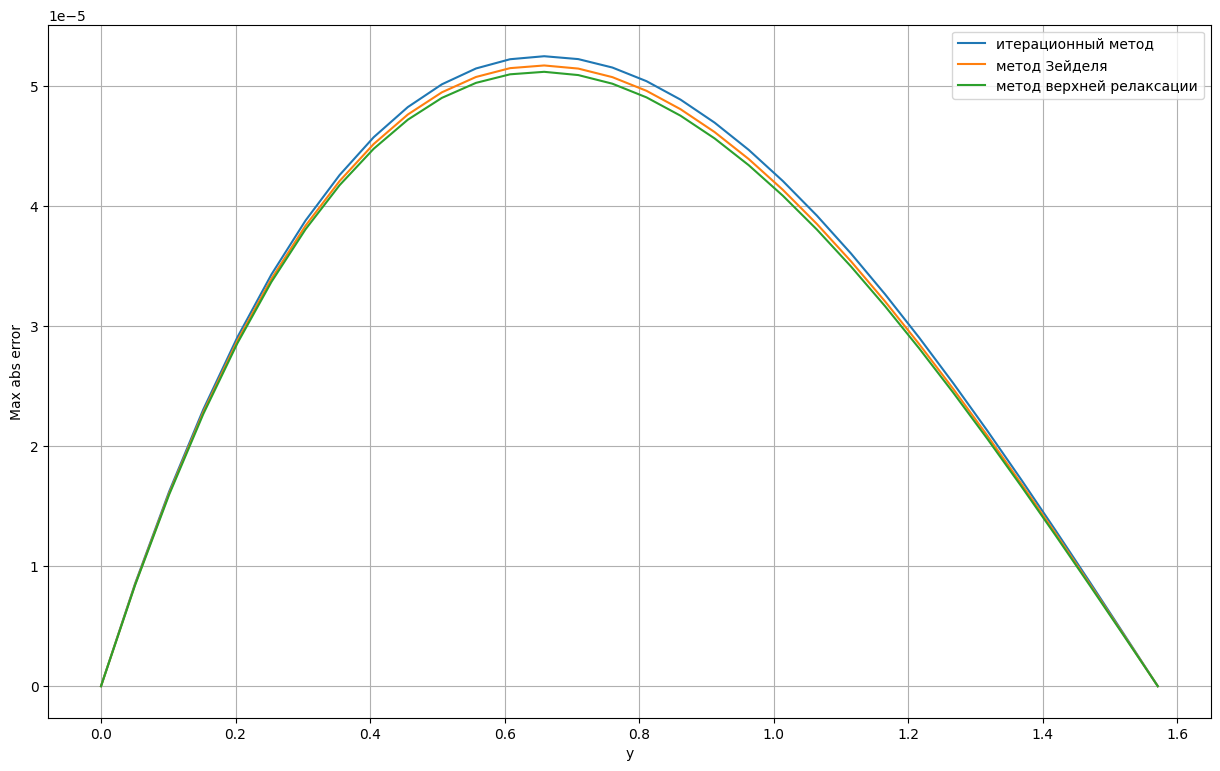

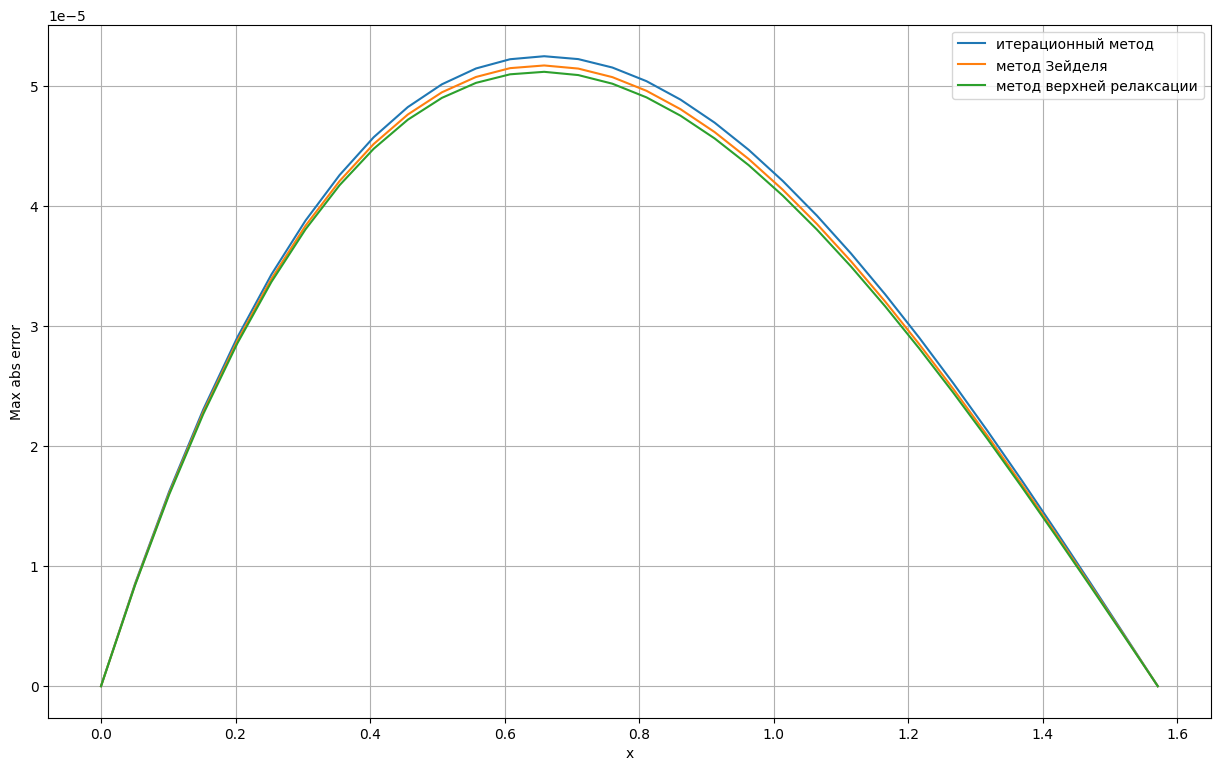

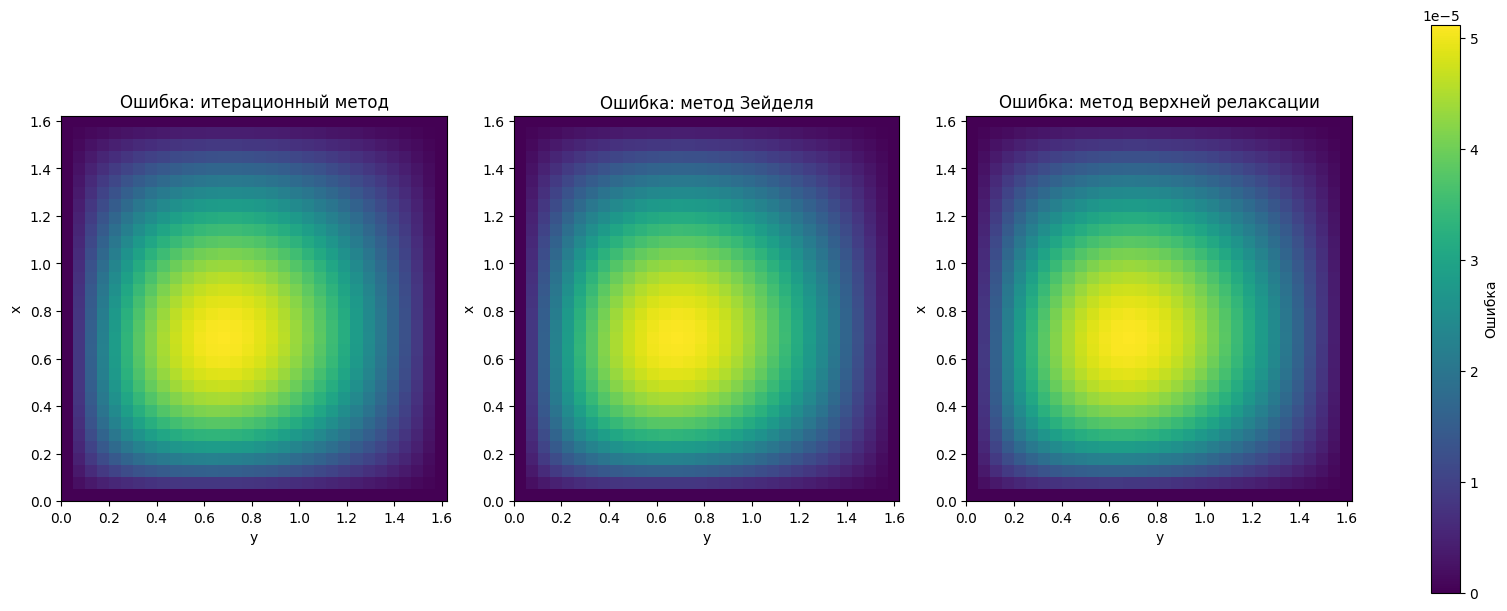

In [65]:
def performing_a_variant_of_laboratory_work(
    l_1=1,  # Граница по x
    l_2=math.pi / 2,  # Граница по y
    h_x_desired=0.05,  # Желаемый шаг по x
    h_y_desired=0.05,  # Желаемый шаг по y
    a=0,  # Коэффициент перед ∂u/∂x
    b=0,  # Коэффициент перед ∂u/∂y
    c=1,  # Коэффициент перед u
    f=f,  # Источниковый член в выражении ∂²u/∂x² + ∂²u/∂y² + a * ∂u/∂x + b * ∂u/∂y = f
    alpha_1=1,  # Коэффициент перед ∂/∂x u(0, y)
    beta_1=0,  # Коэффициент перед u(0, y)
    alpha_2=1,  # Коэффициент перед ∂/∂x u(l₁, y)
    beta_2=-1,  # Коэффициент перед u(l₁, y)
    alpha_3=0,  # Коэффициент перед ∂/∂y u(x, 0)
    beta_3=1,  # Коэффициент перед u(x, 0)
    alpha_4=0,  # Коэффициент перед ∂/∂y u(x, l₂)
    beta_4=1,  # Коэффициент перед u(x, l₂)
    phi_1=phi_1,  # Граничное условие для 0 по x
    phi_2=phi_2,  # Граничное условие для l₁ по x
    phi_3=phi_3,  # Граничное условие для 0 по y
    phi_4=phi_4,  # Граничное условие для l₂ по y
    cur_init=True,  # флаг управления линейной интерполяции неизвестных компонент
    cur_theta=1.5,  # коэффициент метода верхней релаксации (для получения просто Зейделя нужен коэффициент = 1), в методе простых итераций не используется
    cur_eps=1e-7,  # точность решения
    direction_of_traversing_the_matrix="↘",  # ↘↙↖↗ - всевозможные обходы матрицы
):
    N_x = math.ceil(l_1 / h_x_desired)
    N_y = math.ceil(l_2 / h_y_desired)

    h_x = (l_1 - 0) / (N_x - 1)
    h_y = (l_2 - 0) / (N_y - 1)

    x_begin = 0
    x_end = l_1 + h_x

    y_begin = 0
    y_end = l_2 + h_y

    exact_solution = get_exact_solution(
        x_range=(x_begin, x_end),
        y_range=(y_begin, y_end),
        h_x=h_x,
        h_y=h_y,
    )

    solutions_3 = dict()

    solutions_3["аналитическое решение"] = exact_solution

    print("Итерационный метод:")
    iterative_solution, iterative_iters = diff_scheme(
        x_range=(x_begin, x_end),
        y_range=(y_begin, y_end),
        h_x=h_x,
        h_y=h_y,
        a=a,
        b=b,
        c=c,
        f=f,
        alpha_1=alpha_1,
        beta_1=beta_1,
        alpha_2=alpha_2,
        beta_2=beta_2,
        alpha_3=alpha_3,
        beta_3=beta_3,
        alpha_4=alpha_4,
        beta_4=beta_4,
        phi_1=phi_1,
        phi_2=phi_2,
        phi_3=phi_3,
        phi_4=phi_4,
        method_name="Метод простых итераций",
        initial=cur_init,
        eps=cur_eps,
        direction_of_traversing_the_matrix=direction_of_traversing_the_matrix,
    )

    solutions_3["итерационный метод"] = iterative_solution

    print(f"Модуль максимальной ошибки = {max_abs_error(iterative_solution, exact_solution)}")
    print(f"Модуль средней ошибки = {mean_abs_error(iterative_solution, exact_solution)}")
    print(f"Количество итераций = {iterative_iters}")
    print()

    print("Метод Зейделя:")
    seidel_solution, seidel_iters = diff_scheme(
        x_range=(x_begin, x_end),
        y_range=(y_begin, y_end),
        h_x=h_x,
        h_y=h_y,
        a=a,
        b=b,
        c=c,
        f=f,
        alpha_1=alpha_1,
        beta_1=beta_1,
        alpha_2=alpha_2,
        beta_2=beta_2,
        alpha_3=alpha_3,
        beta_3=beta_3,
        alpha_4=alpha_4,
        beta_4=beta_4,
        phi_1=phi_1,
        phi_2=phi_2,
        phi_3=phi_3,
        phi_4=phi_4,
        method_name="Метод Зейделя",
        initial=cur_init,
        theta=1,
        eps=cur_eps,
        direction_of_traversing_the_matrix=direction_of_traversing_the_matrix,
    )

    solutions_3["метод Зейделя"] = seidel_solution

    print(f"Модуль максимальной ошибки = {max_abs_error(seidel_solution, exact_solution)}")
    print(f"Модуль средней ошибки = {mean_abs_error(seidel_solution, exact_solution)}")
    print(f"Количество итераций = {seidel_iters}")
    print()

    print("Метод верхней релаксации:")
    relaxation_solution, relaxation_iters = diff_scheme(
        x_range=(x_begin, x_end),
        y_range=(y_begin, y_end),
        h_x=h_x,
        h_y=h_y,
        a=a,
        b=b,
        c=c,
        f=f,
        alpha_1=alpha_1,
        beta_1=beta_1,
        alpha_2=alpha_2,
        beta_2=beta_2,
        alpha_3=alpha_3,
        beta_3=beta_3,
        alpha_4=alpha_4,
        beta_4=beta_4,
        phi_1=phi_1,
        phi_2=phi_2,
        phi_3=phi_3,
        phi_4=phi_4,
        method_name="Метод верхней релаксации",
        initial=cur_init,
        theta=cur_theta,
        eps=cur_eps,
        direction_of_traversing_the_matrix=direction_of_traversing_the_matrix,
    )

    solutions_3["метод верхней релаксации"] = relaxation_solution

    print(f"Модуль максимальной ошибки = {max_abs_error(relaxation_solution, exact_solution)}")
    print(f"Модуль средней ошибки = {mean_abs_error(relaxation_solution, exact_solution)}")
    print(f"Количество итераций = {relaxation_iters}")
    print()

    plot_results_by_y_slider(
        solutions=solutions_3,
        x_range=(x_begin, x_end),
        y_range=(y_begin, y_end),
        h_x=h_x,
        h_y=h_y,
    )

    plot_results_by_x_slider(
        solutions=solutions_3,
        x_range=(x_begin, x_end),
        y_range=(y_begin, y_end),
        h_x=h_x,
        h_y=h_y,
    )

    plot_errors_from_y(
        solutions=solutions_3,
        exact_solution_name="аналитическое решение",
        y_range=(y_begin, y_end),
        h_y=h_y,
    )

    plot_errors_from_x(
        solutions=solutions_3,
        exact_solution_name="аналитическое решение",
        x_range=(x_begin, x_end),
        h_x=h_x,
    )

    heatmaps_err(
        solutions=solutions_3,
        exact_solution_name="аналитическое решение",
        x_range=(x_begin, x_end),
        y_range=(y_begin, y_end),
        h_x=h_x,
        h_y=h_y,
    )

    plot_interactive_error_surfaces(
        solutions=solutions_3,
        exact_solution_name="аналитическое решение",
        x_range=(x_begin, x_end),
        y_range=(y_begin, y_end),
        h_x=h_x,
        h_y=h_y,
    )


performing_a_variant_of_laboratory_work(
    l_1=l_1,
    l_2=l_2,
    h_x_desired=h_x_desired,
    h_y_desired=h_y_desired,
    a=a,
    b=b,
    c=c,
    f=f,
    alpha_1=alpha_1,
    beta_1=beta_1,
    alpha_2=alpha_2,
    beta_2=beta_2,
    alpha_3=alpha_3,
    beta_3=beta_3,
    alpha_4=alpha_4,
    beta_4=beta_4,
    phi_1=phi_1,
    phi_2=phi_2,
    phi_3=phi_3,
    phi_4=phi_4,
    cur_init=cur_init,
    cur_theta=cur_theta,
    cur_eps=cur_eps,
    direction_of_traversing_the_matrix=cur_dir,
)